# Graph Convolutional Networks

The Graphical Convolutional Network (GCN) is a scalable approach presented by Kipf and Welling (2016) for semi-supervised learning on graph-structured data. It is based on a variant of convolutional neural networks that operate directly on graphs.

Similar to the convolution operation, convolution in GCNs involves the model learning features by examining neighbouring nodes. If we consider that CNNs are designed to operate on Euclidean structured data, GNNs can be considered the generalized version of CNNs, as they can handle varying numbers of node connections and unordered nodes on irregular or non-Euclidean structured data.

Given an undirected graph $\mathcal{G}$, Kipf and Welling (2016) proposed a multi-layer GCN that employs the following layer-wise propagation rule

$$
\textbf{H}^{(l)} = \sigma \left( \tilde{\textbf{D}}^{-\frac{1}{2}} \tilde{\textbf{A}} \tilde{\textbf{D}}^{-\frac{1}{2}} \textbf{H}^{(l-1)} \textbf{W}^{(l-1)} \right)
$$

and the definition of the spectral convolution of a signal $x$ with a filter $g_{\theta'}$ at each iteration $k \in K$

$$
g_{\theta'} \star x \approx \sum^K_{k=0} \theta'_k T_k (\tilde{\textbf{L}})x
$$

where

- $\textbf{H}^{(l)}$ is the matrix of node representations at layer $l$
- $\sigma$ is the activation function
- $\textbf{W}$ is the trainable parameter matrix
- the Chebyshev polynomials are recursively defined as $T_k(x) = 2xT_{k-1}(x) - T_{k-2}(x)$
- $\theta' \in \mathbb{R}^K$ is a vector of Chebyshev coefficients
- given the identity matrix $\textbf{I}$ and the normalized graph Laplacian $\textbf{L}$
    - $\tilde{\textbf{A}} = \textbf{A} + \textbf{I}$ is the graph adjacency matrix with added self-connections
    - $\tilde{\textbf{D}}_{ii} = \sum_j \tilde{\textbf{A}} _{ij}$
    - $\tilde{\textbf{L}} = \frac{2}{\lambda_{\text{max}}}\textbf{L} - \textbf{I}$ (here $\lambda_{\text{max}}$ denotes the largest eigenvalue of $\textbf{L}$)

In [1]:
import math
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from model.dgl.DGLModel import DGLModel
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd

In [3]:
TRN = Dataset.load_csv("ds/all/TRN_DC")
TST1 = Dataset.load_csv("ds/all/TST_1")
TST2 = Dataset.load_csv("ds/all/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[64], [64, 64], [64, 128], [64, 128, 256]]),
    "gnn_norm": tune.choice(["right", "both", "none"]),
    "residual": tune.choice([True, False]),
    "batchnorm": tune.choice([True, False]),
    "dropout": tune.uniform(0, 1),
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "weight_decay": tune.uniform(0, 0.5),
    "epoch": tune.choice([100, 200, 300])
}

In [6]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=config["hidden_feats"],
        gnn_norm=config["gnn_norm"],
        activation=relu,
        residual=config["residual"],
        batchnorm=config["batchnorm"],
        dropout=config["dropout"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # General DGL Configuration
        lr=config["lr"],
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False,
        device=torch.device("cpu")
    )
    scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=10),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-11 16:12:41,823	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_8a5c1_00003,2023-03-11_16-16-06,False,,6e50c5c12eff487ab275ff97c59d3444,64-4090-13700K,1,127.0.0.1,30636,3.55183,194.414,194.414,194.414,1678551366,0,,1,8a5c1_00003,0.00399828


2023-03-11 17:16:16,409	INFO tune.py:798 -- Total run time: 3811.02 seconds (3810.92 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'hidden_feats': [64, 128, 256],
 'gnn_norm': 'both',
 'residual': True,
 'batchnorm': False,
 'dropout': 0.26852001317510277,
 'lr': 0.001,
 'weight_decay': 0.0036332647333098267,
 'epoch': 300}

In [9]:
MODEL = GCN(
    task_type="regression",
    # GCN Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=best_result.config["hidden_feats"],
    gnn_norm=best_result.config["gnn_norm"],
    activation=relu,
    residual=best_result.config["residual"],
    batchnorm=best_result.config["batchnorm"],
    dropout=best_result.config["dropout"],
    classifier_hidden_feats=128,
    classifier_dropout=0,
    predictor_hidden_feats=128,
    predictor_dropout=0,
    # Abstract DGL Configuration
    lr=best_result.config["lr"],
    y_name="LogS exp (mol/L)",
    weight_decay=best_result.config["weight_decay"],
    batch_size=4096
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=best_result.config["epoch"])

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


100%|██████████| 300/300 [01:44<00:00,  2.86it/s, rmse: 1.104]


<AxesSubplot: >

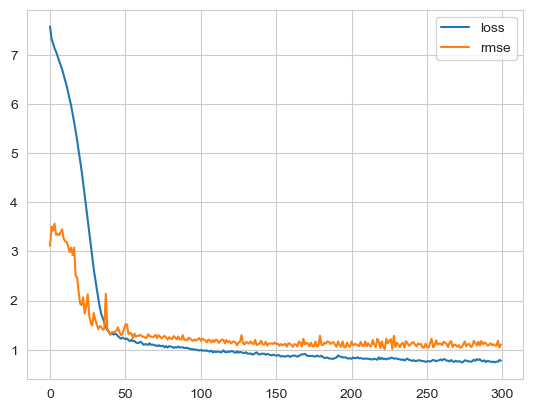

In [10]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [ ]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=best_result.config["epoch"],
    extra_eval_set=TST1,
    cv=5,
    verbose=True
)

In [ ]:
np.std(result["rmse"]), np.mean(result["rmse"])

In [12]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 0.8736018283892
TST2 : RMSE 1.4274647657356738


In [16]:
def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm='both',
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=config["dropout"],
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # General DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=config["weight_decay"],
        batch_size=4096,
        verbose=False,
        device=torch.device("cpu")
    )
    scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
    tune.report(rmse=scores["rmse"][-1])

In [17]:
SPACE = {
    'dropout': tune.uniform(0, 0.35),
    'weight_decay': tune.uniform(0, 0.01),
    'epoch': tune.uniform(10, 500)
}

In [23]:
from ray.tune.search.bayesopt import BayesOptSearch

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=BayesOptSearch(metric="rmse", mode="min"),
    dataset=TRN
)
tune_result = tuner.fit()

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_0ac2a0db,2023-03-11_18-27-03,False,,bb4a8bf375654f6db1b1b08446108d98,64-4090-13700K,1,127.0.0.1,18648,1.25992,1651.49,1651.49,1651.49,1678559223,0,,1,0ac2a0db,0.00499892


2023-03-11 18:27:04,477	INFO tune.py:798 -- Total run time: 1654.85 seconds (1654.84 seconds for the tuning loop).


In [24]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'dropout': 0.13108904159657686,
 'weight_decay': 0.007319939418114051,
 'epoch': 475.8500101408589}

In [7]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu

AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm="both",
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=0.13108904159657686,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.007319939418114051,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=800, min_epoch=450, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 59%|█████▉    | 474/800 [02:44<01:53,  2.88it/s, loss: 0.995 rmse: 1.004]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 61%|██████    | 489/800 [02:44<01:44,  2.97it/s, loss: 0.851 rmse: 1.689]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 62%|██████▏   | 493/800 [02:53<01:48,  2.84it/s, loss: 0.845 rmse: 1.589]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 60%|█████▉    | 477/800 [02:25<01:38,  3.27it/s, loss: 0.993 rmse: 0.817]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 61%|██████▏   | 490/800 [02:23<01:30,  3.42it/s, loss: 0.981 rmse: 1.251]


In [8]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [9]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 0.7624478474796559
TST2 : RMSE 1.1172902313588031


In [10]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.6372268834946557
TST2 : R^2 0.7278508628917646


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (GCN)\nRMSE: 1.117, $R^2$: 0.728')

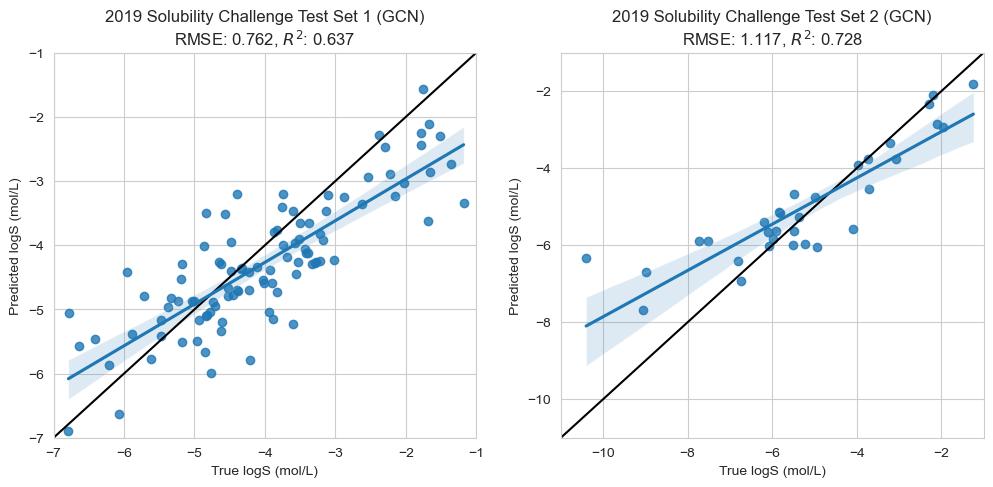

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")

In [3]:
TRN = Dataset.load_csv("ds/exclude_CSD/TRN_DC")
TST1 = Dataset.load_csv("ds/all/TST_1")
TST2 = Dataset.load_csv("ds/all/TST_2")

In [6]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [7]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [19]:
from model.dgl.GCN import GCN
from torch.nn.functional import relu

AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GCN(
        task_type="regression",
        # GCN Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[64, 128, 256],
        gnn_norm="both",
        activation=relu,
        residual=True,
        batchnorm=False,
        dropout=0.13108904159657686,
        classifier_hidden_feats=128,
        classifier_dropout=0,
        predictor_hidden_feats=128,
        predictor_dropout=0,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.007319939418114051,
        batch_size=4096
    )
    model.fit(trn, val=val, epochs=800, min_epoch=300, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 44%|████▍     | 351/800 [00:21<00:27, 16.26it/s, loss: 0.093 rmse: 1.342]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 43%|████▎     | 342/800 [00:22<00:29, 15.35it/s, loss: 0.108 rmse: 0.753]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 42%|████▏     | 333/800 [00:20<00:29, 15.86it/s, loss: 0.101 rmse: 0.667]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 42%|████▏     | 335/800 [00:19<00:27, 16.77it/s, loss: 0.098 rmse: 0.923]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 41%|████      | 327/800 [00:19<00:28, 16.50it/s, loss: 0.090 rmse: 0.709]


In [20]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [21]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : RMSE 0.8826044670815036
TST2 : RMSE 1.4039900714265938
TST1 : R^2 0.5138760109512976
TST2 : R^2 0.5702627191460683


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (GCN)\nRMSE: 1.404, $R^2$: 0.570')

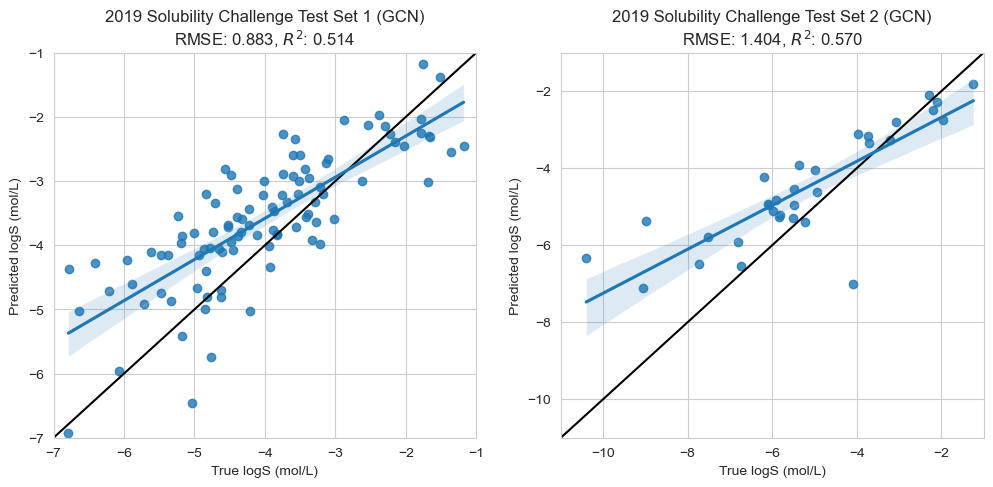

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GCN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")